In [1]:
import random
import h5py
import numpy as np
from torch.utils.data import Dataset
import torch
from torch import nn
import os
import copy
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import warnings

# Preparing Train and Validation Dataset


In [2]:

class TrainDataset(Dataset):
    def __init__(self, h5_file, patch_size, scale):
        super(TrainDataset, self).__init__()
        self.h5_file = h5_file
        self.patch_size = patch_size
        self.scale = scale

    @staticmethod
    def random_crop(lr, hr, size, scale):
        lr_left = random.randint(0, lr.shape[1] - size)
        lr_right = lr_left + size
        lr_top = random.randint(0, lr.shape[0] - size)
        lr_bottom = lr_top + size
        hr_left = lr_left * scale
        hr_right = lr_right * scale
        hr_top = lr_top * scale
        hr_bottom = lr_bottom * scale
        lr = lr[lr_top:lr_bottom, lr_left:lr_right]
        hr = hr[hr_top:hr_bottom, hr_left:hr_right]
        return lr, hr

    @staticmethod
    def random_horizontal_flip(lr, hr):
        if random.random() < 0.5:
            lr = lr[:, ::-1, :].copy()
            hr = hr[:, ::-1, :].copy()
        return lr, hr

    @staticmethod
    def random_vertical_flip(lr, hr):
        if random.random() < 0.5:
            lr = lr[::-1, :, :].copy()
            hr = hr[::-1, :, :].copy()
        return lr, hr

    @staticmethod
    def random_rotate_90(lr, hr):
        if random.random() < 0.5:
            lr = np.rot90(lr, axes=(1, 0)).copy()
            hr = np.rot90(hr, axes=(1, 0)).copy()
        return lr, hr

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            lr = f['lr'][str(idx)][::]
            hr = f['hr'][str(idx)][::]
            lr, hr = self.random_crop(lr, hr, self.patch_size, self.scale)
            lr, hr = self.random_horizontal_flip(lr, hr)
            lr, hr = self.random_vertical_flip(lr, hr)
            lr, hr = self.random_rotate_90(lr, hr)
            lr = lr.astype(np.float32).transpose([2, 0, 1]) / 255.0
            hr = hr.astype(np.float32).transpose([2, 0, 1]) / 255.0
            return lr, hr

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])


class EvalDataset(Dataset):
    def __init__(self, h5_file):
        super(EvalDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            lr = f['lr'][str(idx)][::].astype(np.float32).transpose([2, 0, 1]) / 255.0
            hr = f['hr'][str(idx)][::].astype(np.float32).transpose([2, 0, 1]) / 255.0
            return lr, hr

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

# PSNR Calculation and Benchmarking


In [3]:
import torch
import numpy as np


def convert_rgb_to_y(img, dim_order='hwc'):
    if dim_order == 'hwc':
        return 16. + (64.738 * img[..., 0] + 129.057 * img[..., 1] + 25.064 * img[..., 2]) / 256.
    else:
        return 16. + (64.738 * img[0] + 129.057 * img[1] + 25.064 * img[2]) / 256.


def denormalize(img):
    img = img.mul(255.0).clamp(0.0, 255.0)
    return img


def preprocess(img, device):
    img = np.array(img).astype(np.float32)
    ycbcr = convert_rgb_to_ycbcr(img)
    x = ycbcr[..., 0]
    x /= 255.
    x = torch.from_numpy(x).to(device)
    x = x.unsqueeze(0).unsqueeze(0)
    return x, ycbcr


def calc_psnr(img1, img2, max=255.0):
    return 10. * ((max ** 2) / ((img1 - img2) ** 2).mean()).log10()


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Residual Dense Network Model

In [4]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return torch.cat([x, self.relu(self.conv(x))], 1)


class RDB(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(RDB, self).__init__()
        self.layers = nn.Sequential(*[DenseLayer(in_channels + growth_rate * i, growth_rate) for i in range(num_layers)])

        # local feature fusion
        self.lff = nn.Conv2d(in_channels + growth_rate * num_layers, growth_rate, kernel_size=1)

    def forward(self, x):
        return x + self.lff(self.layers(x))  # local residual learning


class RDN(nn.Module):
    def __init__(self, scale_factor, num_channels, num_features, growth_rate, num_blocks, num_layers):
        super(RDN, self).__init__()
        self.G0 = num_features
        self.G = growth_rate
        self.D = num_blocks
        self.C = num_layers

        # shallow feature extraction
        self.sfe1 = nn.Conv2d(num_channels, num_features, kernel_size=3, padding=3 // 2)
        self.sfe2 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=3 // 2)

        # residual dense blocks
        self.rdbs = nn.ModuleList([RDB(self.G0, self.G, self.C)])
        for _ in range(self.D - 1):
            self.rdbs.append(RDB(self.G, self.G, self.C))

        # global feature fusion
        self.gff = nn.Sequential(
            nn.Conv2d(self.G * self.D, self.G0, kernel_size=1),
            nn.Conv2d(self.G0, self.G0, kernel_size=3, padding=3 // 2)
        )

        # up-sampling
        assert 2 <= scale_factor <= 4
        if scale_factor == 2 or scale_factor == 4:
            self.upscale = []
            for _ in range(scale_factor // 2):
                self.upscale.extend([nn.Conv2d(self.G0, self.G0 * (2 ** 2), kernel_size=3, padding=3 // 2),
                                     nn.PixelShuffle(2)])
            self.upscale = nn.Sequential(*self.upscale)
        else:
            self.upscale = nn.Sequential(
                nn.Conv2d(self.G0, self.G0 * (scale_factor ** 2), kernel_size=3, padding=3 // 2),
                nn.PixelShuffle(scale_factor)
            )

        self.output = nn.Conv2d(self.G0, num_channels, kernel_size=3, padding=3 // 2)

    def forward(self, x):
        sfe1 = self.sfe1(x)
        sfe2 = self.sfe2(sfe1)

        x = sfe2
        local_features = []
        for i in range(self.D):
            x = self.rdbs[i](x)
            local_features.append(x)

        x = self.gff(torch.cat(local_features, 1)) + sfe1  # global residual learning
        x = self.upscale(x)
        x = self.output(x)
        return x
    
model = RDN(scale_factor=3,
                num_channels=3,
                num_features=64,
                growth_rate=64,
                num_blocks=16,
                num_layers=8)
print(model)

RDN(
  (sfe1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sfe2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rdbs): ModuleList(
    (0): RDB(
      (layers): Sequential(
        (0): DenseLayer(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
        )
        (1): DenseLayer(
          (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
        )
        (2): DenseLayer(
          (conv): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
        )
        (3): DenseLayer(
          (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
        )
        (4): DenseLayer(
          (conv): Conv2d(320, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
      

# Training


In [ ]:
train_file = "C:\\Users\\hp\\Downloads\\DIV2K_x3.h5"
patch_size = 32
scale =3
batch_size =16
num_workers = 0
eval_file = "C:\\Users\\hp\\Desktop\\7th Sem\\Orbo\\Set5_x3.h5"
num_epochs = 100
lr =  1e-4
seed =123
outputs_dir = "C:\\Users\\hp\\Desktop\\7th Sem\\Outputs"
weights_file = ""

cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(seed)
model = RDN(scale_factor=3,
                num_channels=3,
                num_features=64,
                growth_rate=64,
                num_blocks=16,
                num_layers=8).to(device)


criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_dataset = TrainDataset(train_file, patch_size= patch_size, scale= scale)
train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True)
eval_dataset = EvalDataset(eval_file)
eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=1)

best_weights = copy.deepcopy(model.state_dict())
best_epoch = 0
best_psnr = 0.0

for epoch in range(num_epochs):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr * (0.1 ** (epoch // int(num_epochs * 0.8)))

    model.train()
    epoch_losses = AverageMeter()

    with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size), ncols=80) as t:
        t.set_description('epoch: {}/{}'.format(epoch, num_epochs - 1))

        for data in train_dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)
            #print(preds.shape)
            warnings.filterwarnings("ignore")
            preds = preds+torch.nn.functional.interpolate(inputs,mode ='bilinear',scale_factor = 3)

            loss = criterion(preds, labels)

            epoch_losses.update(loss.item(), len(inputs))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t.set_postfix(loss='{:.6f}'.format(epoch_losses.avg))
            t.update(len(inputs))

    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), os.path.join(outputs_dir, 'epoch_{}.pth'.format(epoch)))

    model.eval()
    epoch_psnr = AverageMeter()

    for data in eval_dataloader:
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            preds = model(inputs)

        preds = convert_rgb_to_y(denormalize(preds.squeeze(0)), dim_order='chw')
        labels = convert_rgb_to_y(denormalize(labels.squeeze(0)), dim_order='chw')

        preds = preds[scale:-scale, scale:-scale]
        labels = labels[scale:-scale, scale:-scale]

        epoch_psnr.update(calc_psnr(preds, labels), len(inputs))

    print('eval psnr: {:.2f}'.format(epoch_psnr.avg))

    if epoch_psnr.avg > best_psnr:
        best_epoch = epoch
        best_psnr = epoch_psnr.avg
        best_weights = copy.deepcopy(model.state_dict())
print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))

# Testing

In [42]:
import PIL.Image as pil_image

weights_file = "C:\\Users\\hp\\Desktop\\7th Sem\\Outputs\\rdn_x3.pth"
scale =3
image_file = "C:\\Users\\hp\\Desktop\\7th Sem\\Data\\moon.png"
cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = RDN(scale_factor=scale,
                num_channels=3,
                num_features=64,
                growth_rate=64,
                num_blocks=16,
                num_layers=8).to(device)

state_dict = model.state_dict()
for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)

model.eval()

image = pil_image.open(image_file).convert('RGB')

image_width = (image.width //scale) * scale
image_height = (image.height //scale) * scale

hr = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
lr = hr.resize((hr.width //scale, hr.height //scale), resample=pil_image.BICUBIC)
bicubic = lr.resize((lr.width *scale, lr.height *scale), resample=pil_image.BICUBIC)
bicubic.save(image_file.replace('.', '_bicubic_x{}.'.format(scale)))

lr = np.expand_dims(np.array(lr).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
hr = np.expand_dims(np.array(hr).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
lr = torch.from_numpy(lr).to(device)
hr = torch.from_numpy(hr).to(device)

with torch.no_grad():
        preds = model(lr).squeeze(0)

preds_y = convert_rgb_to_y(denormalize(preds), dim_order='chw')
hr_y = convert_rgb_to_y(denormalize(hr.squeeze(0)), dim_order='chw')

preds_y = preds_y[scale:-scale,scale:-scale]
hr_y = hr_y[scale:-scale, scale:-scale]

psnr = calc_psnr(hr_y, preds_y)
print('PSNR: {:.2f}'.format(psnr))
output = pil_image.fromarray(denormalize(preds).permute(1, 2, 0).byte().cpu().numpy())
output.save(image_file.replace('.', '_rdn_x{}.'.format(scale)))

PSNR: 37.46


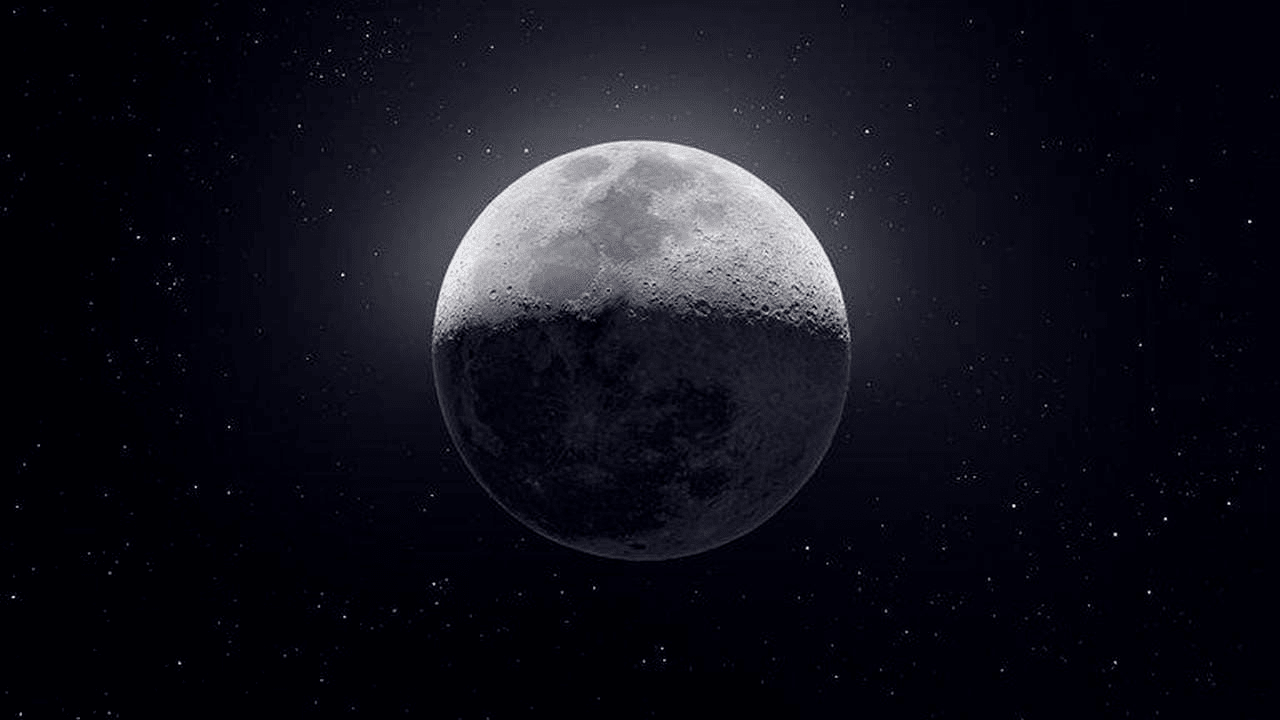

In [43]:
from IPython.display import Image
Image(filename=image_file)


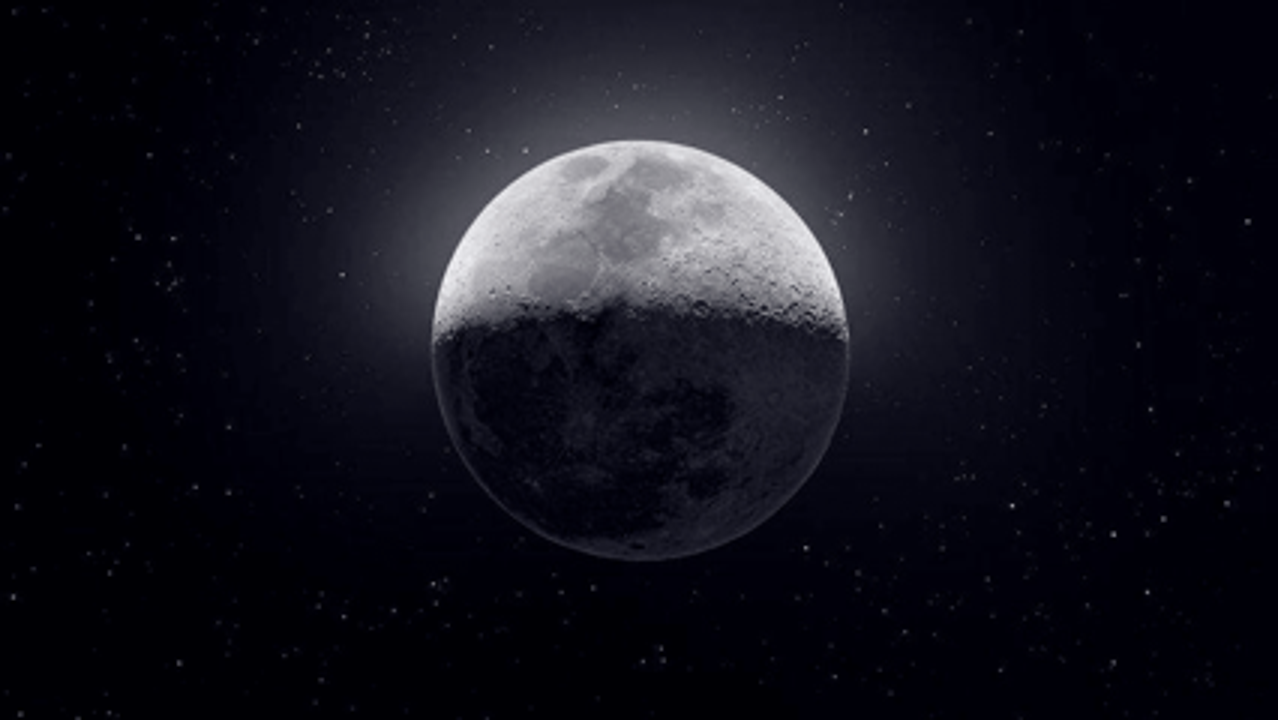

In [44]:
Image(filename=image_file.replace('.', '_bicubic_x{}.'.format(scale)))


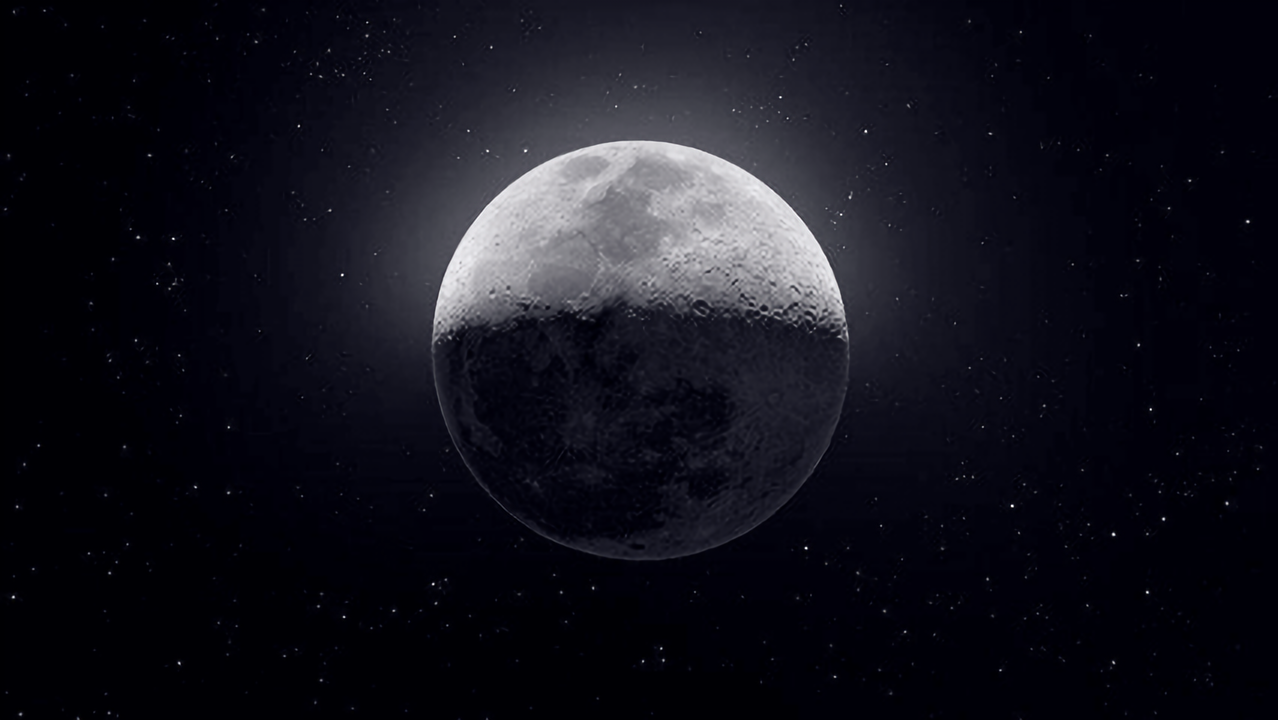

In [45]:
Image(filename=image_file.replace('.', '_rdn_x{}.'.format(scale)))